# Data Mining Assignment 5

## Task 1: Predictions for the test set

### Data Understanding and Data Preparation

In [36]:


import shelve

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [37]:
df_train_original = pd.read_csv('data/weather_train_data.csv')

#### General info

In [38]:
print(df_train_original.head())
print(df_train_original.dtypes)
print('\nRows=' + str(len(df_train_original.index)) + '\n')
print('Columns=' + str(len(df_train_original.columns)) + '\n')



         Date       Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0  2009-09-25    Tuggeranong      3.4     19.7       0.0          NaN   
1  2014-02-02     Townsville     25.3     30.9      38.2         11.0   
2  2016-07-30  NorfolkIsland     14.0     19.2       0.0          NaN   
3  2009-06-14       Richmond      5.4     18.1       0.0          NaN   
4  2011-01-29        Walpole     19.0     24.8       7.8          NaN   

   Sunshine WindGustDir  WindGustSpeed WindDir9am  ... WindSpeed3pm  \
0       NaN          NW           57.0         NW  ...         24.0   
1       3.2         ESE           44.0          E  ...         13.0   
2       NaN         WSW           22.0         SW  ...         13.0   
3       NaN         NNE           28.0        NaN  ...          7.0   
4       NaN          SE           44.0          E  ...         17.0   

   Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  \
0         61.0         35.0       1012.9       1005.1    

In [39]:
df_train_original.describe(exclude=[object])

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,113254.000000,113507.000000,112660.000000,65230.000000,59604.000000,106361.000000,112663.000000,111674.000000,112350.000000,110914.000000,102630.000000,102652.000000,70958.000000,68213.000000,113036.000000,111619.000000
mean,12.189117,23.224917,2.371915,5.473963,7.619400,39.976617,14.016137,18.636164,68.815238,51.470941,1017.658942,1015.260929,4.436188,4.495741,16.986876,21.689802
std,6.400502,7.117415,8.536194,4.217432,3.784245,13.579409,8.905721,8.795008,19.072059,20.801685,7.095282,7.028610,2.888928,2.720098,6.490933,6.936576
min,-8.500000,-4.100000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,0.000000,980.500000,979.000000,0.000000,0.000000,-7.000000,-5.100000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.500000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,31.900000,48.100000,367.600000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1040.900000,1039.600000,8.000000,9.000000,40.200000,46.100000


In [40]:
df_train_original.describe(include=[object])

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday
count,113754,113754,106313,105740,110744,112660
unique,3411,49,16,16,16,2
top,2016-05-12,Canberra,W,N,SE,No
freq,46,2744,7798,9094,8576,87356


In [41]:
# merge predicted labels column
df_train_label_predictions = pd.read_csv('data/weather_train_label.csv', header=None)
df_train_label_predictions.columns = ['RainTomorrow']
df_train_original['RainTomorrow'] = df_train_label_predictions.iloc[:, 0]
df = df_train_original.copy()
df_train_original

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2009-09-25,Tuggeranong,3.4,19.7,0.0,NaN,NaN,NW,57.0,NW,...,61.0,35.0,1012.9,1005.1,NaN,NaN,12.3,19.4,No,Yes
1,2014-02-02,Townsville,25.3,30.9,38.2,11.0,3.2,ESE,44.0,E,...,74.0,89.0,1005.7,1002.9,7.0,7.0,28.0,27.4,Yes,Yes
2,2016-07-30,NorfolkIsland,14.0,19.2,0.0,NaN,NaN,WSW,22.0,SW,...,55.0,51.0,1021.0,1017.9,8.0,NaN,17.1,18.6,No,No
3,2009-06-14,Richmond,5.4,18.1,0.0,NaN,NaN,NNE,28.0,NaN,...,90.0,69.0,1014.8,1011.6,NaN,NaN,7.4,14.2,No,No
4,2011-01-29,Walpole,19.0,24.8,7.8,NaN,NaN,SE,44.0,E,...,99.0,78.0,1013.2,1011.0,NaN,NaN,19.1,23.4,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113749,2015-10-16,Perth,6.8,22.5,0.0,3.8,12.0,SW,35.0,S,...,47.0,40.0,1023.9,1020.6,1.0,0.0,17.2,21.0,No,No
113750,2011-12-06,Richmond,12.1,18.4,0.4,13.6,NaN,SE,31.0,SSW,...,71.0,59.0,1020.6,1018.1,NaN,NaN,15.5,17.2,No,No
113751,2011-03-25,Sydney,17.7,26.7,0.0,8.8,8.0,W,46.0,W,...,50.0,42.0,1007.8,1008.7,NaN,NaN,20.5,24.8,No,No
113752,2011-08-08,SalmonGums,9.4,16.1,2.8,NaN,NaN,W,33.0,NNW,...,91.0,84.0,NaN,NaN,NaN,NaN,11.2,15.4,Yes,Yes


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113754 entries, 0 to 113753
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           113754 non-null  object 
 1   Location       113754 non-null  object 
 2   MinTemp        113254 non-null  float64
 3   MaxTemp        113507 non-null  float64
 4   Rainfall       112660 non-null  float64
 5   Evaporation    65230 non-null   float64
 6   Sunshine       59604 non-null   float64
 7   WindGustDir    106313 non-null  object 
 8   WindGustSpeed  106361 non-null  float64
 9   WindDir9am     105740 non-null  object 
 10  WindDir3pm     110744 non-null  object 
 11  WindSpeed9am   112663 non-null  float64
 12  WindSpeed3pm   111674 non-null  float64
 13  Humidity9am    112350 non-null  float64
 14  Humidity3pm    110914 non-null  float64
 15  Pressure9am    102630 non-null  float64
 16  Pressure3pm    102652 non-null  float64
 17  Cloud9am       70958 non-null

In [43]:
# sort by date
df_sorted = df.sort_values(by=['Date', 'Location'])
df_sorted


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
5903,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes
78109,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes
80649,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes
10407,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes
106464,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79406,2017-06-25,Townsville,16.5,25.8,0.0,NaN,NaN,ESE,31.0,SE,...,61.0,53.0,1018.1,1015.7,8.0,8.0,22.4,24.6,No,No
112828,2017-06-25,WaggaWagga,-0.1,12.7,0.0,NaN,NaN,SSW,19.0,SSW,...,92.0,54.0,1020.8,1018.5,8.0,8.0,4.0,10.7,No,No
12946,2017-06-25,Walpole,9.3,15.4,7.4,NaN,NaN,SSW,20.0,WNW,...,100.0,70.0,1028.7,1026.7,NaN,NaN,9.7,14.6,Yes,No
54631,2017-06-25,Watsonia,7.9,13.0,0.0,2.8,3.8,NNW,39.0,N,...,68.0,69.0,1017.6,1015.3,7.0,7.0,9.0,11.7,No,No


In [44]:
categorical_features = [column_name for column_name in df.columns if df[column_name].dtype == 'O']
print("Number of Categorical Features: {}".format(len(categorical_features)))
print("Categorical Features: ", categorical_features)

Number of Categorical Features: 7
Categorical Features:  ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [45]:
numerical_features = [column_name for column_name in df.columns if df[column_name].dtype != 'O']
print("Number of Numerical Features: {}".format(len(numerical_features)))
print("Numerical Features: ", numerical_features)

Number of Numerical Features: 16
Numerical Features:  ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [46]:
for each_feature in categorical_features:
    unique_values = len(df[each_feature].unique())
    print("Cardinality(no. of unique values) of {} are: {}".format(each_feature, unique_values))

Cardinality(no. of unique values) of Date are: 3411
Cardinality(no. of unique values) of Location are: 49
Cardinality(no. of unique values) of WindGustDir are: 17
Cardinality(no. of unique values) of WindDir9am are: 17
Cardinality(no. of unique values) of WindDir3pm are: 17
Cardinality(no. of unique values) of RainToday are: 3
Cardinality(no. of unique values) of RainTomorrow are: 2


In [47]:
# rearrange date
df['Date'] = pd.to_datetime(df['Date'])
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df.drop('Date', axis=1, inplace=True)
df

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day
0,Tuggeranong,3.4,19.7,0.0,NaN,NaN,NW,57.0,NW,NNW,...,1005.1,NaN,NaN,12.3,19.4,No,Yes,2009,9,25
1,Townsville,25.3,30.9,38.2,11.0,3.2,ESE,44.0,E,E,...,1002.9,7.0,7.0,28.0,27.4,Yes,Yes,2014,2,2
2,NorfolkIsland,14.0,19.2,0.0,NaN,NaN,WSW,22.0,SW,W,...,1017.9,8.0,NaN,17.1,18.6,No,No,2016,7,30
3,Richmond,5.4,18.1,0.0,NaN,NaN,NNE,28.0,NaN,NNW,...,1011.6,NaN,NaN,7.4,14.2,No,No,2009,6,14
4,Walpole,19.0,24.8,7.8,NaN,NaN,SE,44.0,E,SSE,...,1011.0,NaN,NaN,19.1,23.4,Yes,Yes,2011,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113749,Perth,6.8,22.5,0.0,3.8,12.0,SW,35.0,S,SW,...,1020.6,1.0,0.0,17.2,21.0,No,No,2015,10,16
113750,Richmond,12.1,18.4,0.4,13.6,NaN,SE,31.0,SSW,SSW,...,1018.1,NaN,NaN,15.5,17.2,No,No,2011,12,6
113751,Sydney,17.7,26.7,0.0,8.8,8.0,W,46.0,W,S,...,1008.7,NaN,NaN,20.5,24.8,No,No,2011,3,25
113752,SalmonGums,9.4,16.1,2.8,NaN,NaN,W,33.0,NNW,NW,...,NaN,NaN,NaN,11.2,15.4,Yes,Yes,2011,8,8


In [48]:
# check null values
print('Number of NaN:''\n')
df.isna().sum().to_frame('nulls').sort_values(by='nulls', ascending=False)


Number of NaN:



,nulls
Sunshine,54150
Evaporation,48524
Cloud3pm,45541
Cloud9am,42796
Pressure9am,11124
Pressure3pm,11102
WindDir9am,8014
WindGustDir,7441
WindGustSpeed,7393
WindDir3pm,3010


In [49]:
categorical_features = [column_name for column_name in df.columns if df[column_name].dtype == 'O']
cat_null_df = df[categorical_features].isnull().sum().to_frame('nulls').sort_values(by='nulls', ascending=False)
cat_null_df

,nulls
WindDir9am,8014
WindGustDir,7441
WindDir3pm,3010
RainToday,1094
Location,0
RainTomorrow,0


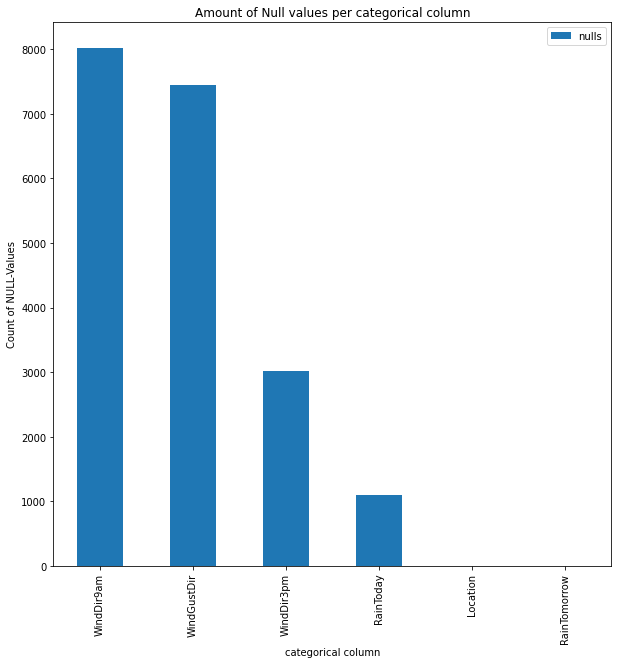

In [50]:
cat_null_df.plot(kind='bar', figsize=(10, 10))
plt.title('Amount of Null values per categorical column')
plt.suptitle('')
plt.xlabel('categorical column')
plt.ylabel('Count of NULL-Values')
plt.savefig('exports/01-null-values-per-col-cat.png')

In [51]:
categorical_features_with_null = [feature for feature in categorical_features if df[feature].isnull().sum()]
for each_feature in categorical_features_with_null:
    mode_val = df[each_feature].mode()[0]
    df[each_feature].fillna(mode_val, inplace=True)

In [52]:
numerical_features = [column_name for column_name in df.columns if df[column_name].dtype != 'O']
num_null_df = df[numerical_features].isnull().sum().to_frame('nulls').sort_values(by='nulls', ascending=False)
num_null_df

,nulls
Sunshine,54150
Evaporation,48524
Cloud3pm,45541
Cloud9am,42796
Pressure9am,11124
Pressure3pm,11102
WindGustSpeed,7393
Humidity3pm,2840
Temp3pm,2135
WindSpeed3pm,2080


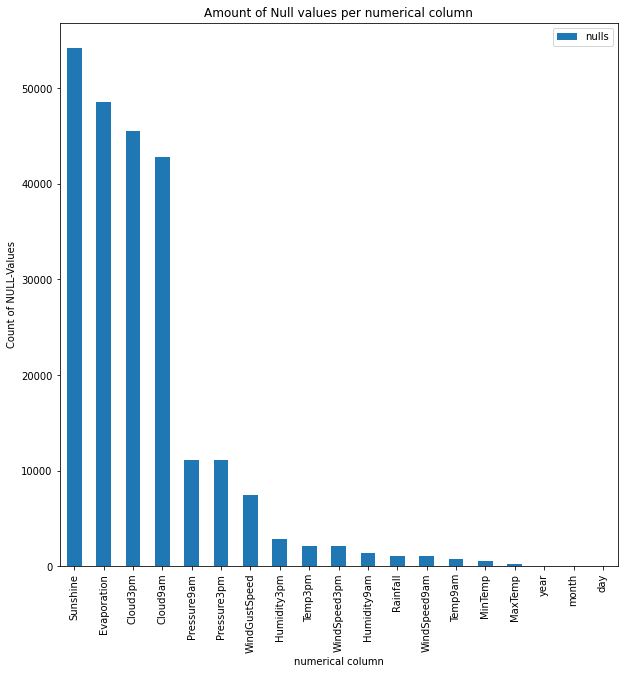

In [53]:
num_null_df.plot(kind='bar', figsize=(10, 10))
plt.title('Amount of Null values per numerical column')
plt.suptitle('')
plt.xlabel('numerical column')
plt.ylabel('Count of NULL-Values')
plt.savefig('exports/02-null-values-per-col-num.png')

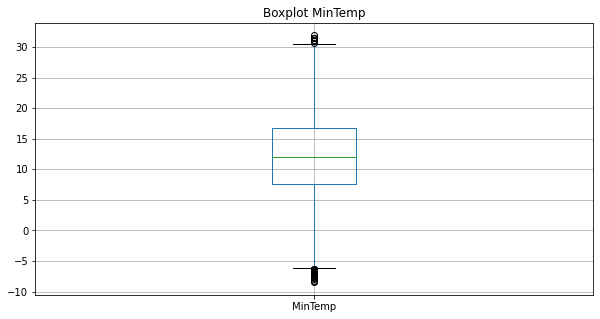

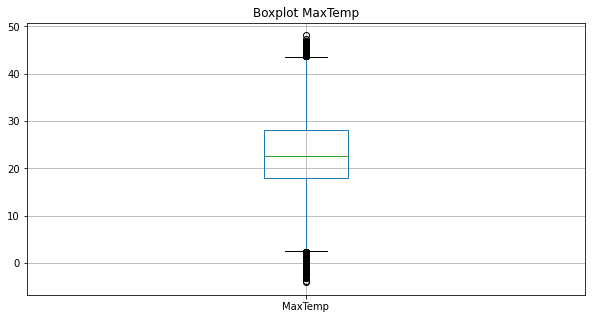

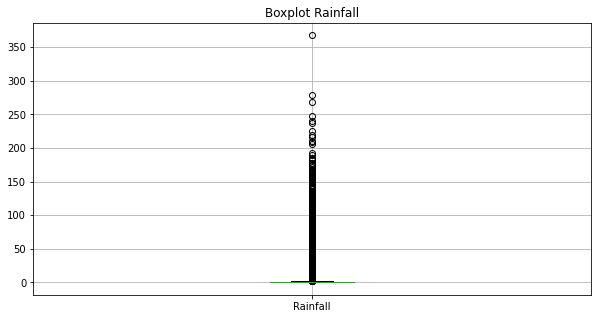

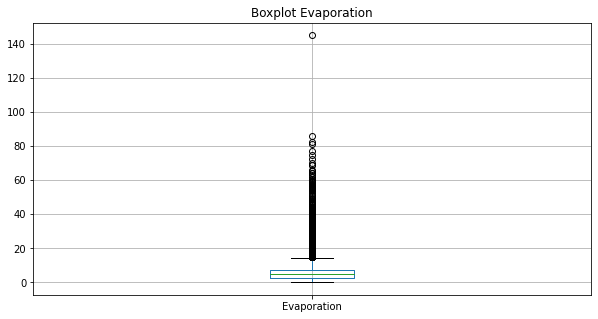

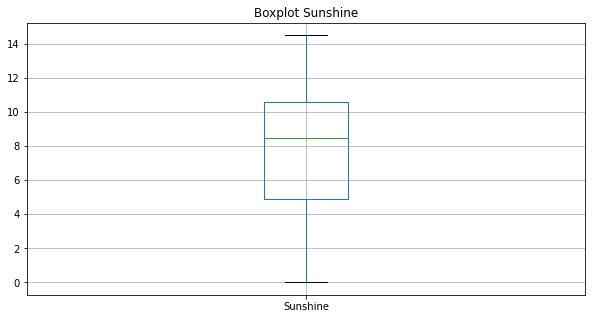

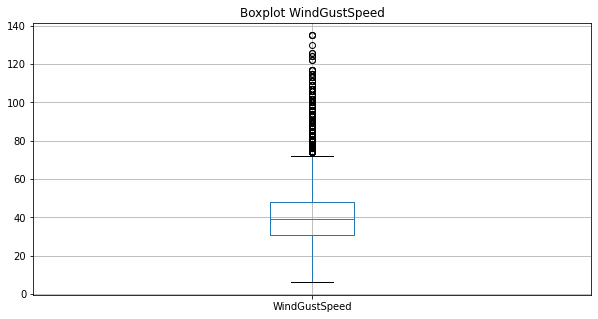

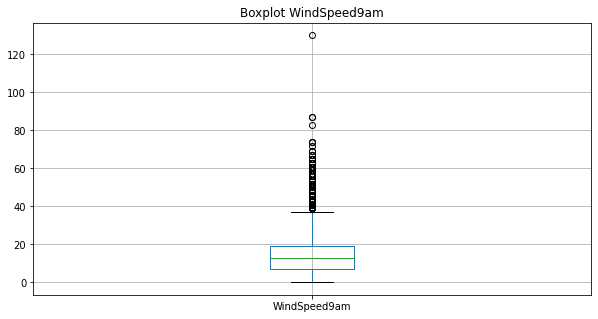

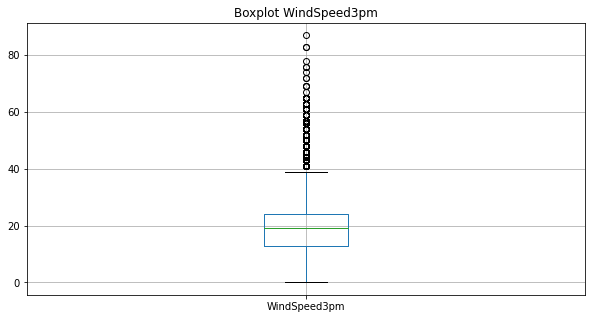

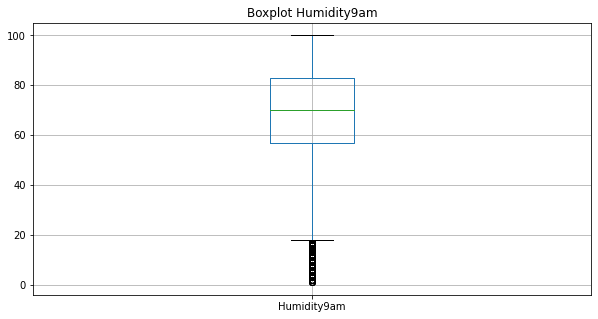

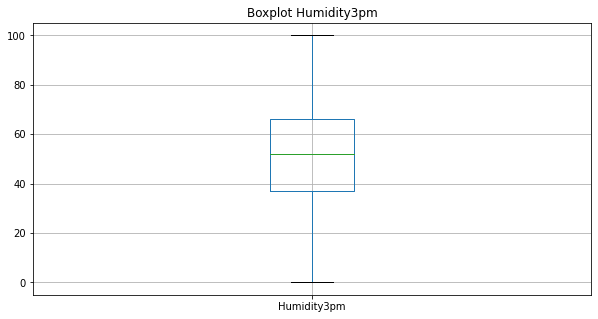

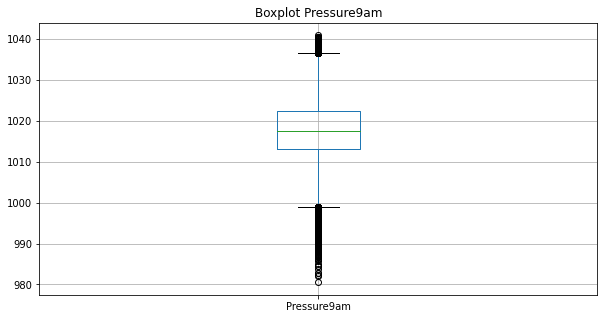

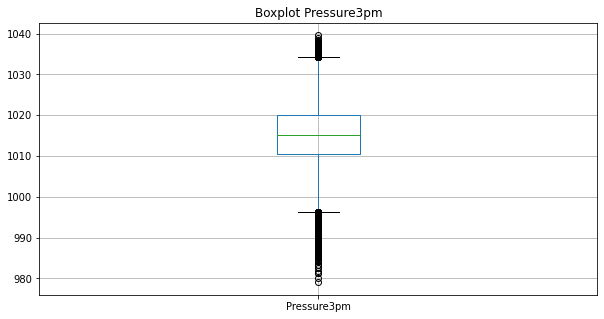

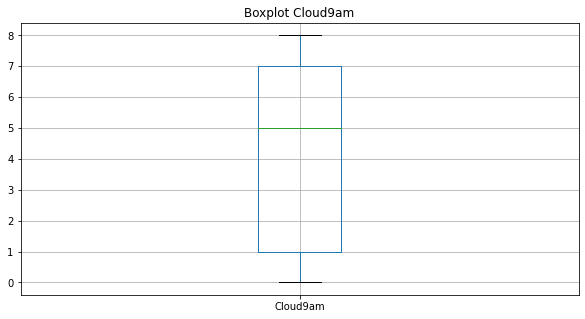

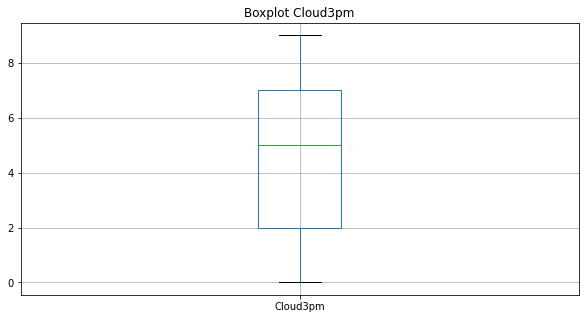

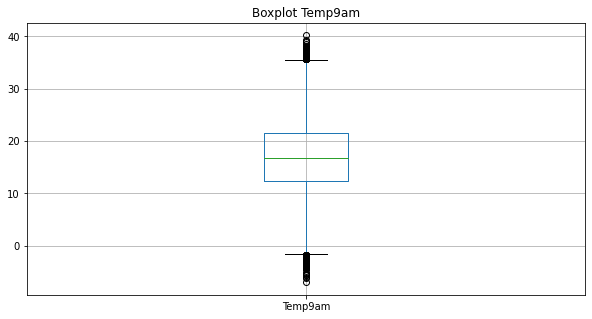

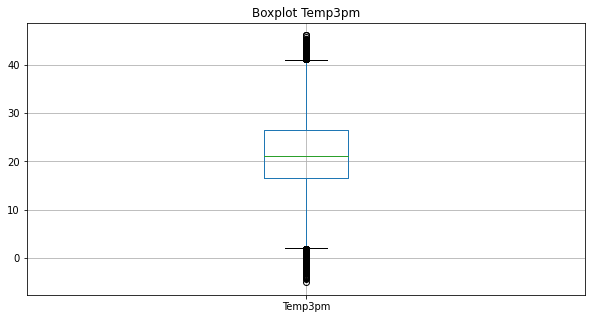

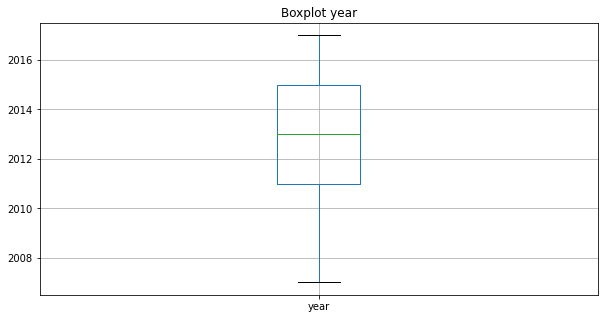

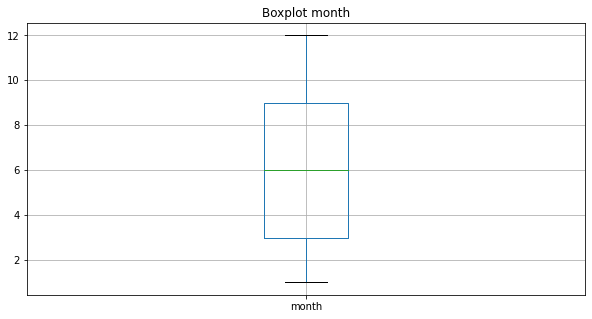

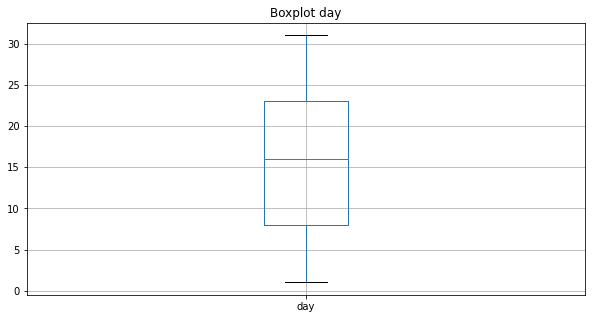

In [54]:
# find cols with outliers to fill Null values with boxplots
for idx, col_name in enumerate(numerical_features):
    df.boxplot(column=col_name, figsize=(10, 5))
    plt.title('Boxplot ' + col_name)
    plt.savefig('exports/03-' + str(idx + 1) + '-bps-' + col_name + '-num.png')
    plt.show()




In [55]:
# eliminate outliers
features_with_outliers = ['Temp3pm',
                          'Temp9am',
                          'Pressure3pm',
                          'Pressure9am',
                          'Humidity9am',
                          'WindSpeed3pm',
                          'WindSpeed9am',
                          'WindGustSpeed',
                          'Evaporation',
                          'Rainfall',
                          'MaxTemp',
                          'MinTemp']
for feature in features_with_outliers:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    IQR = q3 - q1
    lower_limit = q1 - (IQR * 1.5)
    upper_limit = q3 + (IQR * 1.5)
    df.loc[df[feature] < lower_limit, feature] = lower_limit
    df.loc[df[feature] > upper_limit, feature] = upper_limit

numerical_features_with_null = [feature for feature in numerical_features if df[feature].isnull().sum()]
for feature in numerical_features_with_null:
    mean_value = df[feature].mean()
    df[feature].fillna(mean_value, inplace=True)

df

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day
0,Tuggeranong,3.4,19.7,0.0,5.321973,7.6194,NW,57.0,NW,NNW,...,1005.100000,4.436188,4.495741,12.3,19.4,No,Yes,2009,9,25
1,Townsville,25.3,30.9,2.0,11.000000,3.2000,ESE,44.0,E,E,...,1002.900000,7.000000,7.000000,28.0,27.4,Yes,Yes,2014,2,2
2,NorfolkIsland,14.0,19.2,0.0,5.321973,7.6194,WSW,22.0,SW,W,...,1017.900000,8.000000,4.495741,17.1,18.6,No,No,2016,7,30
3,Richmond,5.4,18.1,0.0,5.321973,7.6194,NNE,28.0,N,NNW,...,1011.600000,4.436188,4.495741,7.4,14.2,No,No,2009,6,14
4,Walpole,19.0,24.8,2.0,5.321973,7.6194,SE,44.0,E,SSE,...,1011.000000,4.436188,4.495741,19.1,23.4,Yes,Yes,2011,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113749,Perth,6.8,22.5,0.0,3.800000,12.0000,SW,35.0,S,SW,...,1020.600000,1.000000,0.000000,17.2,21.0,No,No,2015,10,16
113750,Richmond,12.1,18.4,0.4,13.600000,7.6194,SE,31.0,SSW,SSW,...,1018.100000,4.436188,4.495741,15.5,17.2,No,No,2011,12,6
113751,Sydney,17.7,26.7,0.0,8.800000,8.0000,W,46.0,W,S,...,1008.700000,4.436188,4.495741,20.5,24.8,No,No,2011,3,25
113752,SalmonGums,9.4,16.1,2.0,5.321973,7.6194,W,33.0,NNW,NW,...,1015.275116,4.436188,4.495741,11.2,15.4,Yes,Yes,2011,8,8


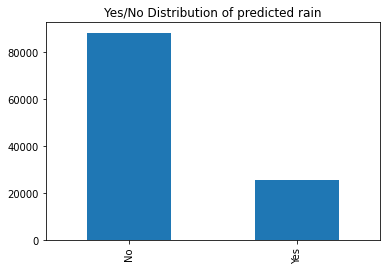

In [56]:
df['RainTomorrow'].value_counts().plot(kind='bar')
plt.title('Yes/No Distribution of predicted rain')
plt.suptitle('')
plt.savefig('exports/04-yes-no-dist.png')

<AxesSubplot:xlabel='Sunshine', ylabel='Rainfall'>

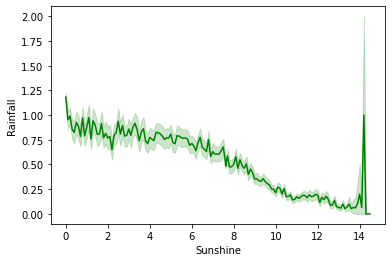

In [57]:
sns.lineplot(data=df, x='Sunshine', y='Rainfall', color='green')

<AxesSubplot:xlabel='Sunshine', ylabel='Evaporation'>

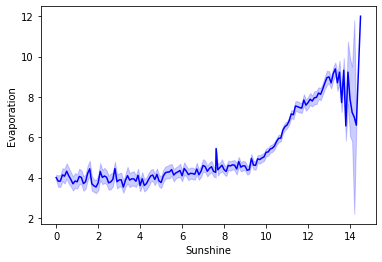

In [58]:
sns.lineplot(data=df, x='Sunshine', y='Evaporation', color='blue')

In [59]:
def encode_data(feature_name):
    """

    This function takes feature name as a parameter and returns mapping dictionary to replace(or map) categorical data with numerical data.

    """

    mapping_dict = {}

    unique_vals = list(df[feature_name].unique())

    for indx in range(len(unique_vals)):
        mapping_dict[unique_vals[indx]] = indx

    s = shelve.open("shelf-data")
    if feature_name == 'WindGustDir':
        s['WindGustDir'] = mapping_dict
    elif feature_name == 'WindDir9am':
        s['WindDir9am'] = mapping_dict
    elif feature_name == 'WindDir3pm':
        s['WindDir3pm'] = mapping_dict
    elif feature_name == 'Location':
        s['Location'] = mapping_dict
    s.close()

    return mapping_dict


df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace=True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace=True)
df['WindGustDir'].replace(encode_data('WindGustDir'), inplace=True)
df['WindDir9am'].replace(encode_data('WindDir9am'), inplace=True)
df['WindDir3pm'].replace(encode_data('WindDir3pm'), inplace=True)
df['Location'].replace(encode_data('Location'), inplace=True)



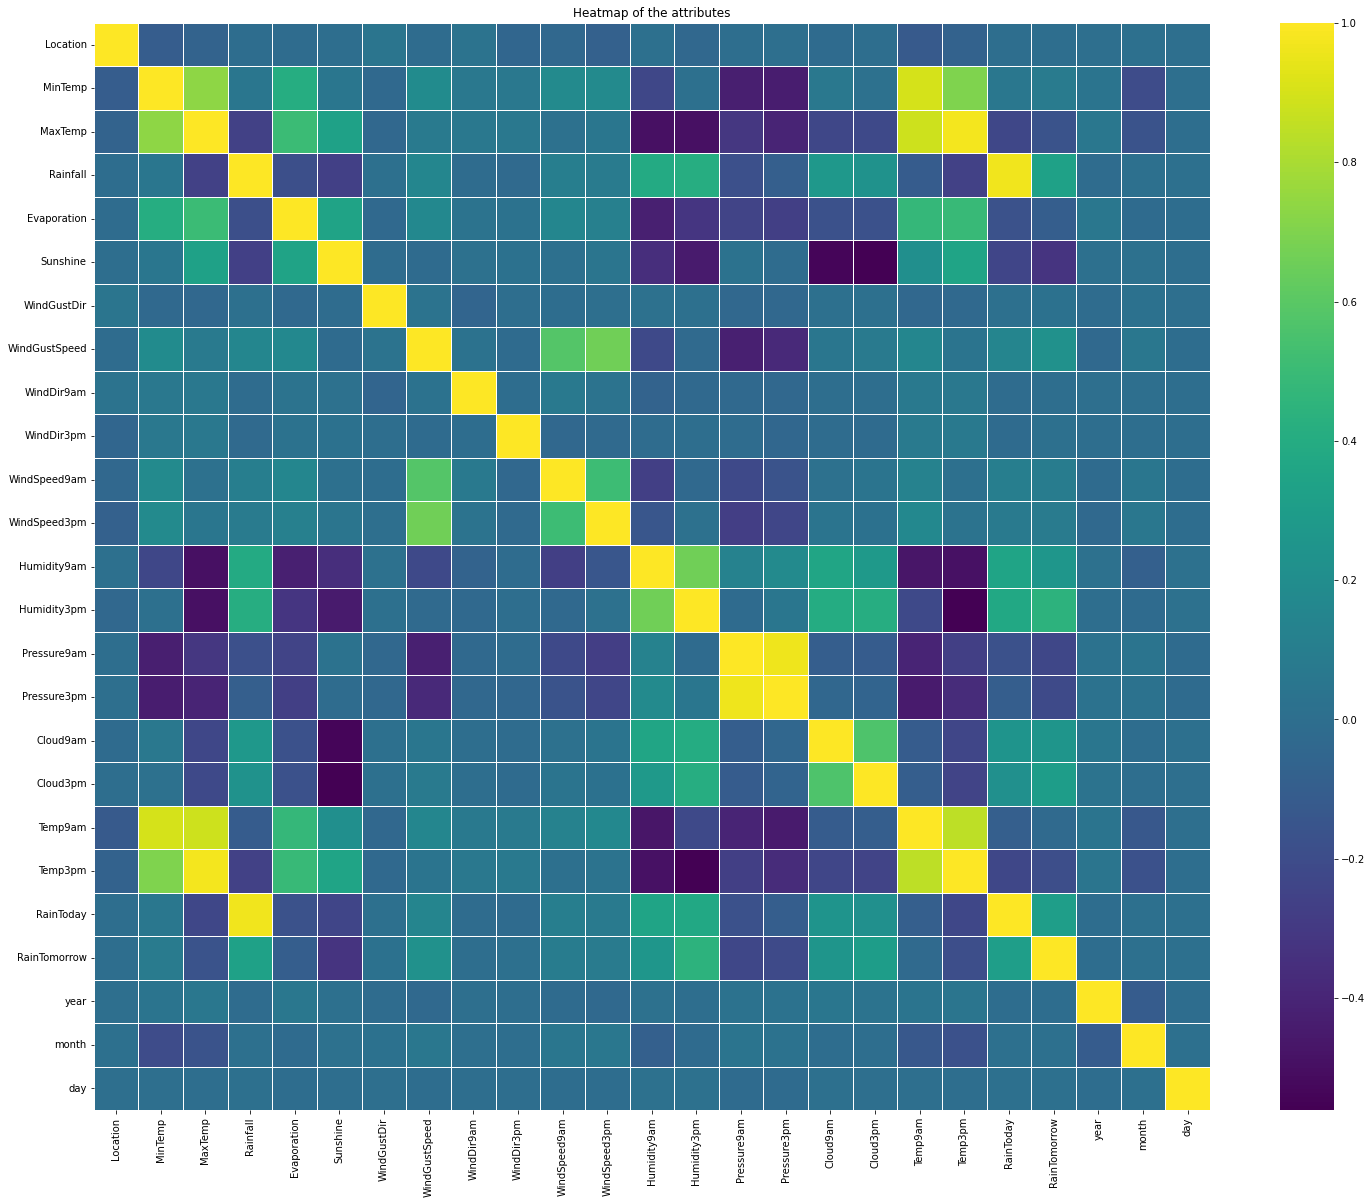

In [60]:
plt.figure(figsize=(25, 20))
sns.heatmap(df.corr(), linewidths=0.5, annot=False, fmt=".2f", cmap='viridis')
plt.title('Heatmap of the attributes')
plt.suptitle('')
plt.savefig('exports/05-heatmap.png')

In [61]:
X = df.drop(['RainTomorrow'], axis=1)
y = df['RainTomorrow']

etr_model = ExtraTreesRegressor()
etr_model.fit(X, y)
etr_model.feature_importances_

array([0.03106666, 0.02941164, 0.02811022, 0.05570104, 0.02363221,
       0.04363289, 0.02966251, 0.05805242, 0.02973983, 0.03125456,
       0.03098228, 0.03243995, 0.03754427, 0.20909889, 0.03512438,
       0.05055187, 0.02426413, 0.03413771, 0.02790615, 0.02818281,
       0.03708677, 0.03036935, 0.02996443, 0.03208303])

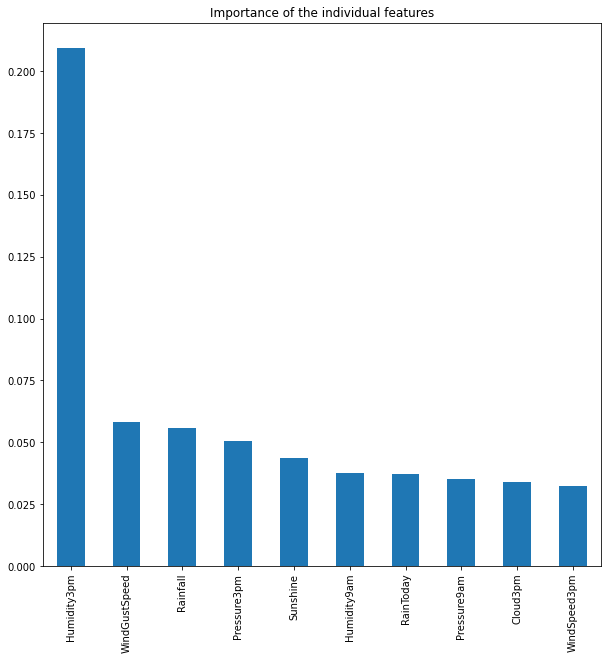

In [62]:

feature_imp = pd.Series(etr_model.feature_importances_, index=X.columns)
feature_imp.nlargest(10).plot(kind='bar', figsize=(10, 10))
plt.title('Importance of the individual features')
plt.suptitle('')
plt.savefig('exports/06-importance-of-features.png')

### Modeling

In [63]:
# create test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [64]:
print("Size of Train-Set: {}".format(len(X_train)))
print("Size of Test-Set: {}".format(len(X_test)))

Size of Train-Set: 91003
Size of Test-Set: 22751


In [65]:
# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

s = shelve.open("shelf-data")
s['X_train'] = X_train
s.close()

accuracy_list = []

In [66]:
# save for later deployment
X_train_save_df = pd.DataFrame(X_train)
X_train_save_df.to_csv(path_or_buf='exports/09-01-X-train.csv', index=False, header=True, sep=';')
y_train_save_df = pd.DataFrame(y_train)
y_train_save_df.to_csv(path_or_buf='exports/09-02-y-train.csv', index=False, header=True, sep=';')



#### Logistic Regression

In [67]:
classifier_logreg = LogisticRegression(solver='liblinear', random_state=0)
classifier_logreg.fit(X_train, y_train)
y_pred = classifier_logreg.predict(X_test)
lr_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {lr_acc}")
print(f"Train Data Score: {classifier_logreg.score(X_train, y_train)}")
print(f"Test Data Score: {classifier_logreg.score(X_test, y_test)}")

accuracy_list.append({'LR': lr_acc})

print(confusion_matrix(y_test, y_pred))

Accuracy Score: 0.8419849676937278
Train Data Score: 0.8427304594354033
Test Data Score: 0.8419849676937278
[[16606   989]
 [ 2606  2550]]


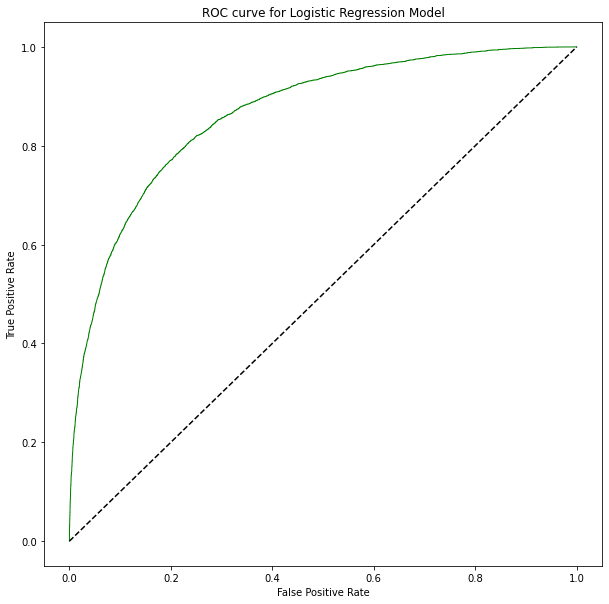

In [68]:
y_pred_logreg_proba = classifier_logreg.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_logreg_proba[:, 1])
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, '-g', linewidth=1)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve for Logistic Regression Model')
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.savefig('exports/07-ROC-curve-log-regression.png')
plt.show()

In [69]:
scores = cross_val_score(classifier_logreg, X_train, y_train, cv=5, scoring='accuracy')
print('Cross-validation scores:{}'.format(scores))
print('Average cross-validation score: {}'.format(scores.mean()))

Cross-validation scores:[0.84055821 0.84154717 0.84423933 0.84186813 0.84456044]
Average cross-validation score: 0.8425546555526775


#### K Nearest Neighbours

In [70]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, y_pred)

print(f"Accuracy Score: {knn_acc}")
print(f"Train Data Score: {knn.score(X_train, y_train)}")
print(f"Test Data Score: {knn.score(X_test, y_test)}")

accuracy_list.append({'KNN': knn_acc})

confusion_matrix(y_test, y_pred)

Accuracy Score: 0.8309524856050283
Train Data Score: 0.8754656439897586
Test Data Score: 0.8309524856050283


array([[16482,  1113],
       [ 2733,  2423]], dtype=int64)

#### Linear Discrimination Analysis

In [71]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
lda_acc = accuracy_score(y_test, y_pred)

print(f"Accuracy Score: {lda_acc}")
print(f"Train Data Score: {lda.score(X_train, y_train)}")
print(f"Test Data Score: {lda.score(X_test, y_test)}")

accuracy_list.append({'LDA': lda_acc})

confusion_matrix(y_test, y_pred)

Accuracy Score: 0.8424245088127994
Train Data Score: 0.8414008329395735
Test Data Score: 0.8424245088127994


array([[16512,  1083],
       [ 2502,  2654]], dtype=int64)

#### Gaussian Naive Bayes

In [72]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
gnb_acc = accuracy_score(y_test, y_pred)

print(f"Accuracy Score: {lda_acc}")
print(f"Train Data Score: {gnb.score(X_train, y_train)}")
print(f"Test Data Score: {gnb.score(X_test, y_test)}")

accuracy_list.append({'GNB': gnb_acc})

confusion_matrix(y_test, y_pred)

Accuracy Score: 0.8424245088127994
Train Data Score: 0.7835236201004363
Test Data Score: 0.7803173486879698


array([[14366,  3229],
       [ 1769,  3387]], dtype=int64)

#### Classification Decision Tree

In [73]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
dtree_acc = accuracy_score(y_test, y_pred)

print(f"Accuracy Score: {dtree_acc}")
print(f"Train Data Score: {clf.score(X_train, y_train)}")
print(f"Test Data Score: {clf.score(X_test, y_test)}")

accuracy_list.append({'CDT': dtree_acc})

confusion_matrix(y_test, y_pred)

Accuracy Score: 0.781943650828535
Train Data Score: 1.0
Test Data Score: 0.781943650828535


array([[15041,  2554],
       [ 2407,  2749]], dtype=int64)

#### Support Vector Machine

In [74]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm = svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred)

print(f"Accuracy Score: {svm_acc}")
print(f"Train Data Score: {svm.score(X_train, y_train)}")
print(f"Test Data Score: {svm.score(X_test, y_test)}")

accuracy_list.append({'SVM': svm_acc})

confusion_matrix(y_test, y_pred)

Accuracy Score: 0.8513032394180475
Train Data Score: 0.861883674164588
Test Data Score: 0.8513032394180475


array([[16940,   655],
       [ 2728,  2428]], dtype=int64)

#### Neural Networks

In [75]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
nn_acc = accuracy_score(y_test, y_pred)

print(f"Accuracy Score: {nn_acc}")
print(f"Train Data Score: {clf.score(X_train, y_train)}")
print(f"Test Data Score: {clf.score(X_test, y_test)}")

accuracy_list.append({'NN': nn_acc})

confusion_matrix(y_test, y_pred)

Accuracy Score: 0.8469517823392378
Train Data Score: 0.849807149214861
Test Data Score: 0.8469517823392378


array([[16630,   965],
       [ 2517,  2639]], dtype=int64)

#### Random Forest

In [76]:
rf_mod = RandomForestClassifier(random_state=0)
rf_mod = rf_mod.fit(X_train, y_train)
y_pred = rf_mod.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred)
print(np.sum(y_pred))

s = shelve.open("shelf-data")
s['rf_mod'] = rf_mod
s.close()

print(f"Accuracy Score: {rf_acc}")
print(f"Train Data Score: {rf_mod.score(X_train, y_train)}")
print(f"Test Data Score: {rf_mod.score(X_test, y_test)}")

accuracy_list.append({'RF': rf_acc})

confusion_matrix(y_test, y_pred)

3309
Accuracy Score: 0.853237220341963
Train Data Score: 0.9999890113512742
Test Data Score: 0.853237220341963


array([[16849,   746],
       [ 2593,  2563]], dtype=int64)

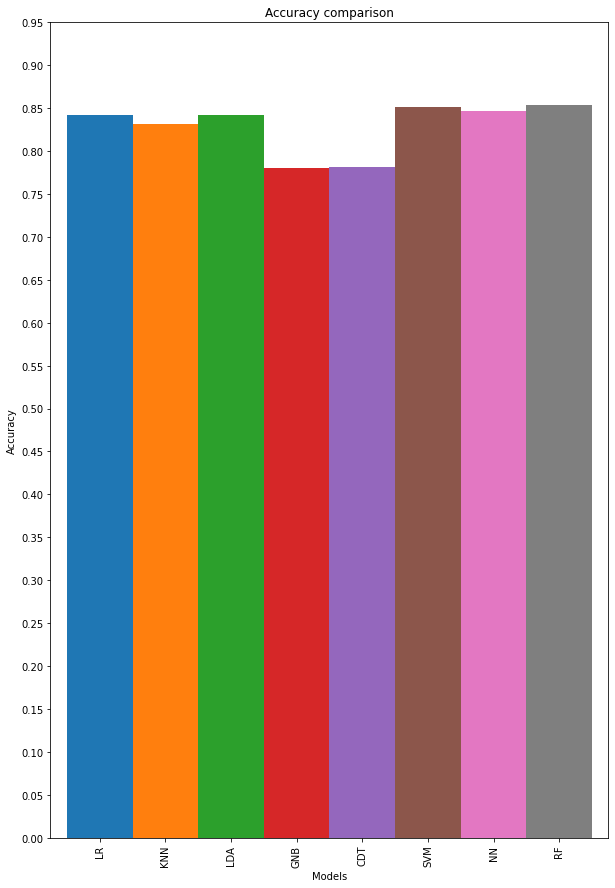

In [77]:
x_labels = []
for entry in accuracy_list:
    for key in entry.keys():
        x_labels.append(key)

acc_df = pd.DataFrame.from_dict(accuracy_list)
acc_df.plot(kind='bar', stacked=True, width=1, figsize=(10, 15), legend=None)
plt.title('Accuracy comparison')
plt.suptitle('')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1, 0.05))
plt.xlabel('Models')
ax = plt.gca()
ax.set_xticklabels(x_labels)
plt.savefig('exports/08-accuracy-comparison.png')

## Apply to test set

In [80]:
# save train data
X_train_appl = df.copy()
# load test data
df_test_X = pd.read_csv('data/weather_test_data.csv')
# rearrange date
df_test_X['Date'] = pd.to_datetime(df_test_X['Date'])
df_test_X['year'] = df_test_X['Date'].dt.year
df_test_X['month'] = df_test_X['Date'].dt.month
df_test_X['day'] = df_test_X['Date'].dt.day
df_test_X.drop('Date', axis=1, inplace=True)
# insert modes for nulls in categorical input
categorical_features = [column_name for column_name in df_test_X.columns if df_test_X[column_name].dtype == 'O']
numerical_features = [column_name for column_name in df_test_X.columns if df_test_X[column_name].dtype != 'O']
categorical_features_with_null = [feature for feature in categorical_features if df_test_X[feature].isnull().sum()]
for each_feature in categorical_features_with_null:
    mode_val = df_test_X[each_feature].mode()[0]
    df_test_X[each_feature].fillna(mode_val, inplace=True)
# eliminate outliers
features_with_outliers = ['Temp3pm',
                          'Temp9am',
                          'Pressure3pm',
                          'Pressure9am',
                          'Humidity9am',
                          'WindSpeed3pm',
                          'WindSpeed9am',
                          'WindGustSpeed',
                          'Evaporation',
                          'Rainfall',
                          'MaxTemp',
                          'MinTemp']
for feature in features_with_outliers:
    q1 = df_test_X[feature].quantile(0.25)
    q3 = df_test_X[feature].quantile(0.75)
    IQR = q3 - q1
    lower_limit = q1 - (IQR * 1.5)
    upper_limit = q3 + (IQR * 1.5)
    df_test_X.loc[df_test_X[feature] < lower_limit, feature] = lower_limit
    df_test_X.loc[df_test_X[feature] > upper_limit, feature] = upper_limit

numerical_features_with_null = [feature for feature in numerical_features if df_test_X[feature].isnull().sum()]
for feature in numerical_features_with_null:
    mean_value = df_test_X[feature].mean()
    df_test_X[feature].fillna(mean_value, inplace=True)


def encode_data(feature_name):
    """
    This function takes feature name as a parameter and returns mapping dictionary to replace(or map) categorical data with numerical data.
    """

    mapping_dict = {}

    unique_vals = list(df_test_X[feature_name].unique())

    for indx in range(len(unique_vals)):
        mapping_dict[unique_vals[indx]] = indx

    return mapping_dict

s = shelve.open('shelf-data')
encoding_windGustDir = s['WindGustDir']
encoding_windDir9am = s['WindDir9am']
encoding_windDir3pm = s['WindDir3pm']
encoding_location = s['Location']


df_test_X['RainToday'].replace({'No': 0, 'Yes': 1}, inplace=True)
df_test_X['WindGustDir'].replace(encoding_windGustDir, inplace=True)
df_test_X['WindDir9am'].replace(encoding_windDir9am, inplace=True)
df_test_X['WindDir3pm'].replace(encoding_windDir3pm, inplace=True)
df_test_X['Location'].replace(encoding_location, inplace=True)

# scale data
scaler_cust = StandardScaler()
X_train_appl.drop('RainTomorrow', axis=1, inplace=True)
X_train_appl = scaler_cust.fit_transform(X_train_appl)
df_test_X = scaler_cust.transform(df_test_X)

y_pred = rf_mod.predict(df_test_X)
print(np.sum(y_pred))
y_pred = np.where(y_pred == 0, 'No', 'Yes')
pred_df = pd.DataFrame(y_pred)
pred_df.to_csv(path_or_buf='exports/10-rain-predictions-test-set.csv', index=False, header=False, sep=';')

3872


##### References
Most of the code consists of refactored code from [scikit-learn](https://scikit-learn.org/) and [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2021/06/predictive-modelling-rain-prediction-in-australia-with-python/)
